# Student Dropout Prediction & Academic Success


This notebook implements a supervised machine learning pipeline to predict whether a student will dropout, stay enrolled, or graduate. The solution involves data preprocessing, feature analysis, handling class imbalance using SMOTE, and comparing three distinct algorithms: Logistic Regression, SVM, and Random Forest.

In [36]:
# 1. Import Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE  

# 3. Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# 4. Evaluation Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# 5. Configuration
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore') # Clean up output by hiding warnings


## 1. Data Loading and Initial Inspection
Here we load the dataset and perform a basic check of the structure, dimensions, and missing values.

In [37]:
df = pd.read_csv('data.csv') 
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## 2. Exploratory Data Analysis (EDA)


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [39]:
df.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance\t                        int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        

In [40]:
df.shape

(4424, 37)

### Check missing values

In [41]:
df.isnull().sum().sum()

np.int64(0)

### Check duplicate values

In [42]:
duplicate = df.duplicated().sum()
duplicate

np.int64(0)

### Correlation Analysis


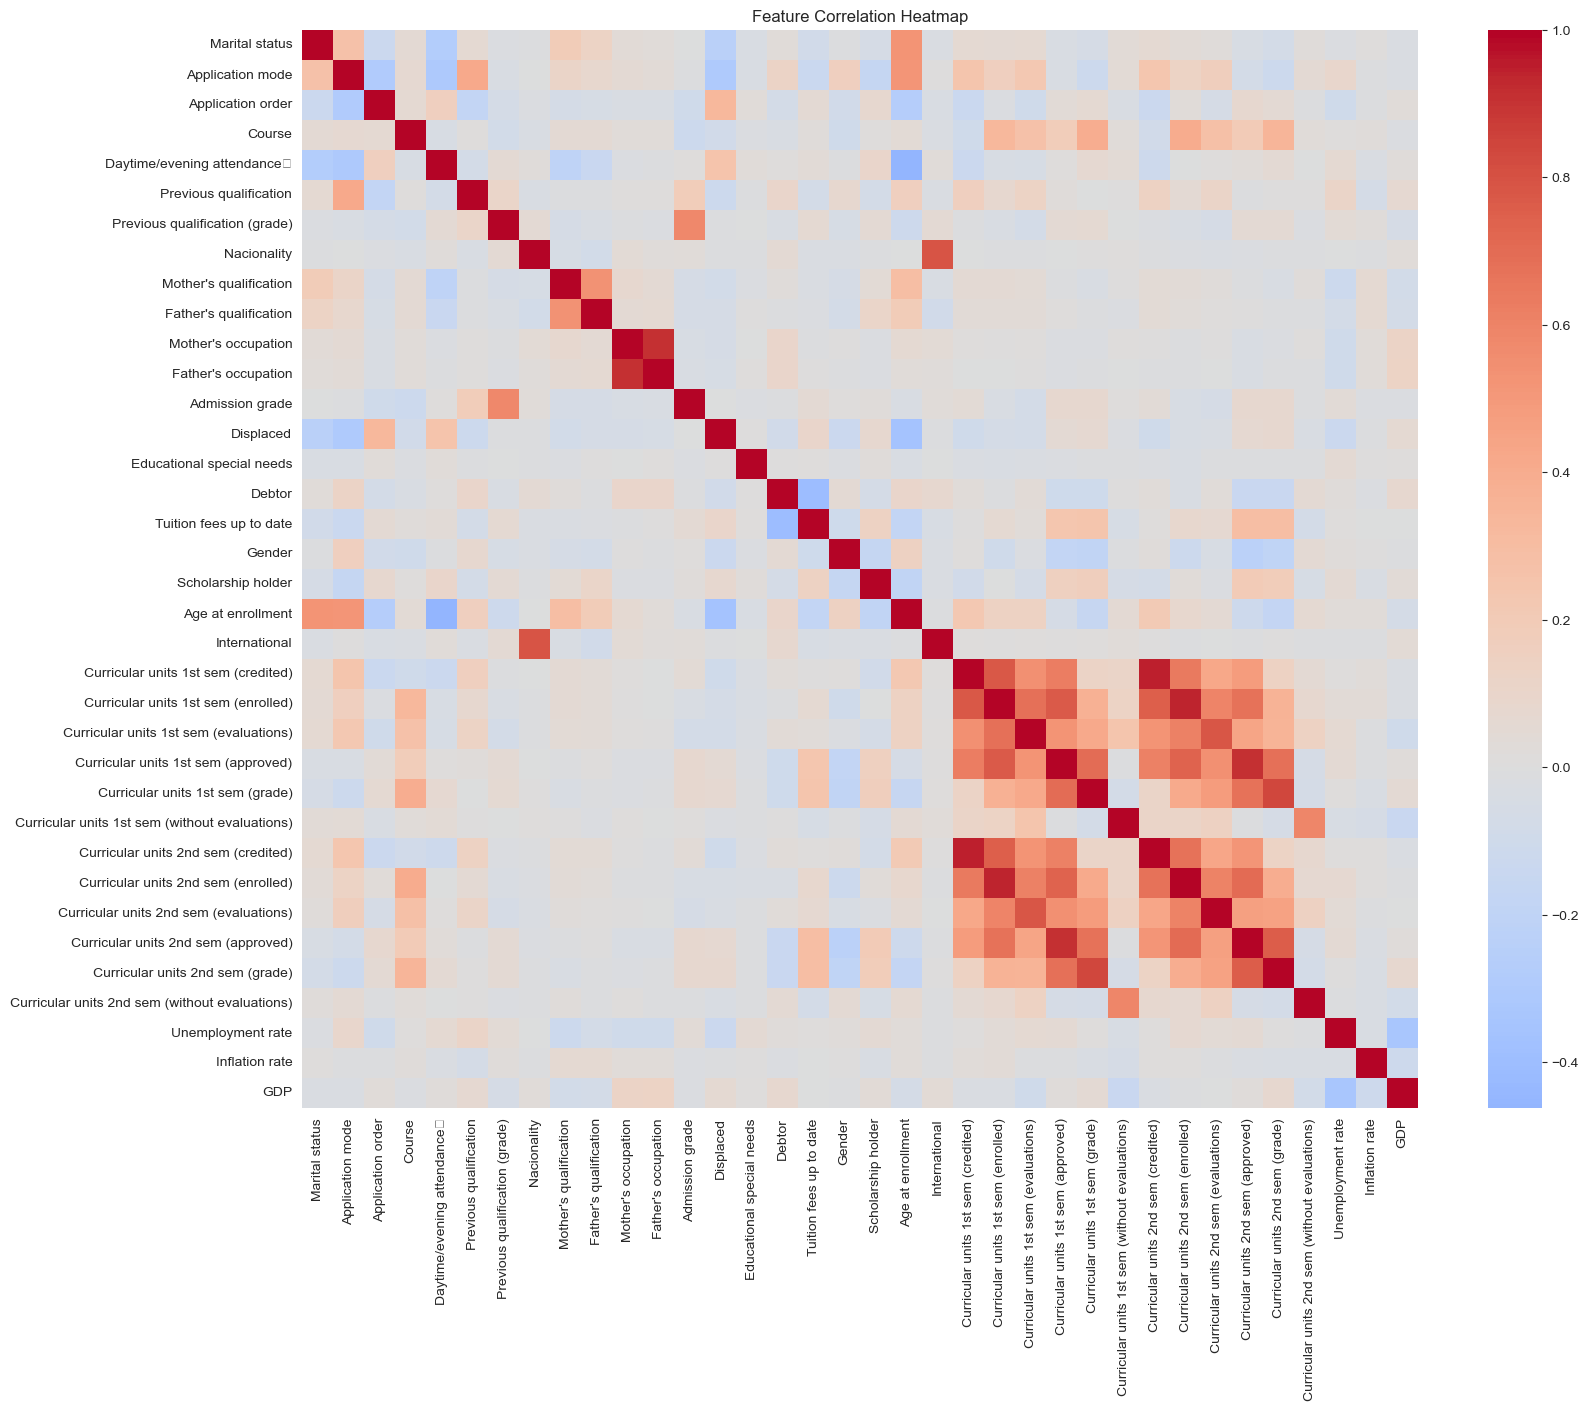

In [43]:
plt.figure(figsize=(18, 14))
corr = df.drop(['Target'], axis=1).corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


### Feature Distribution

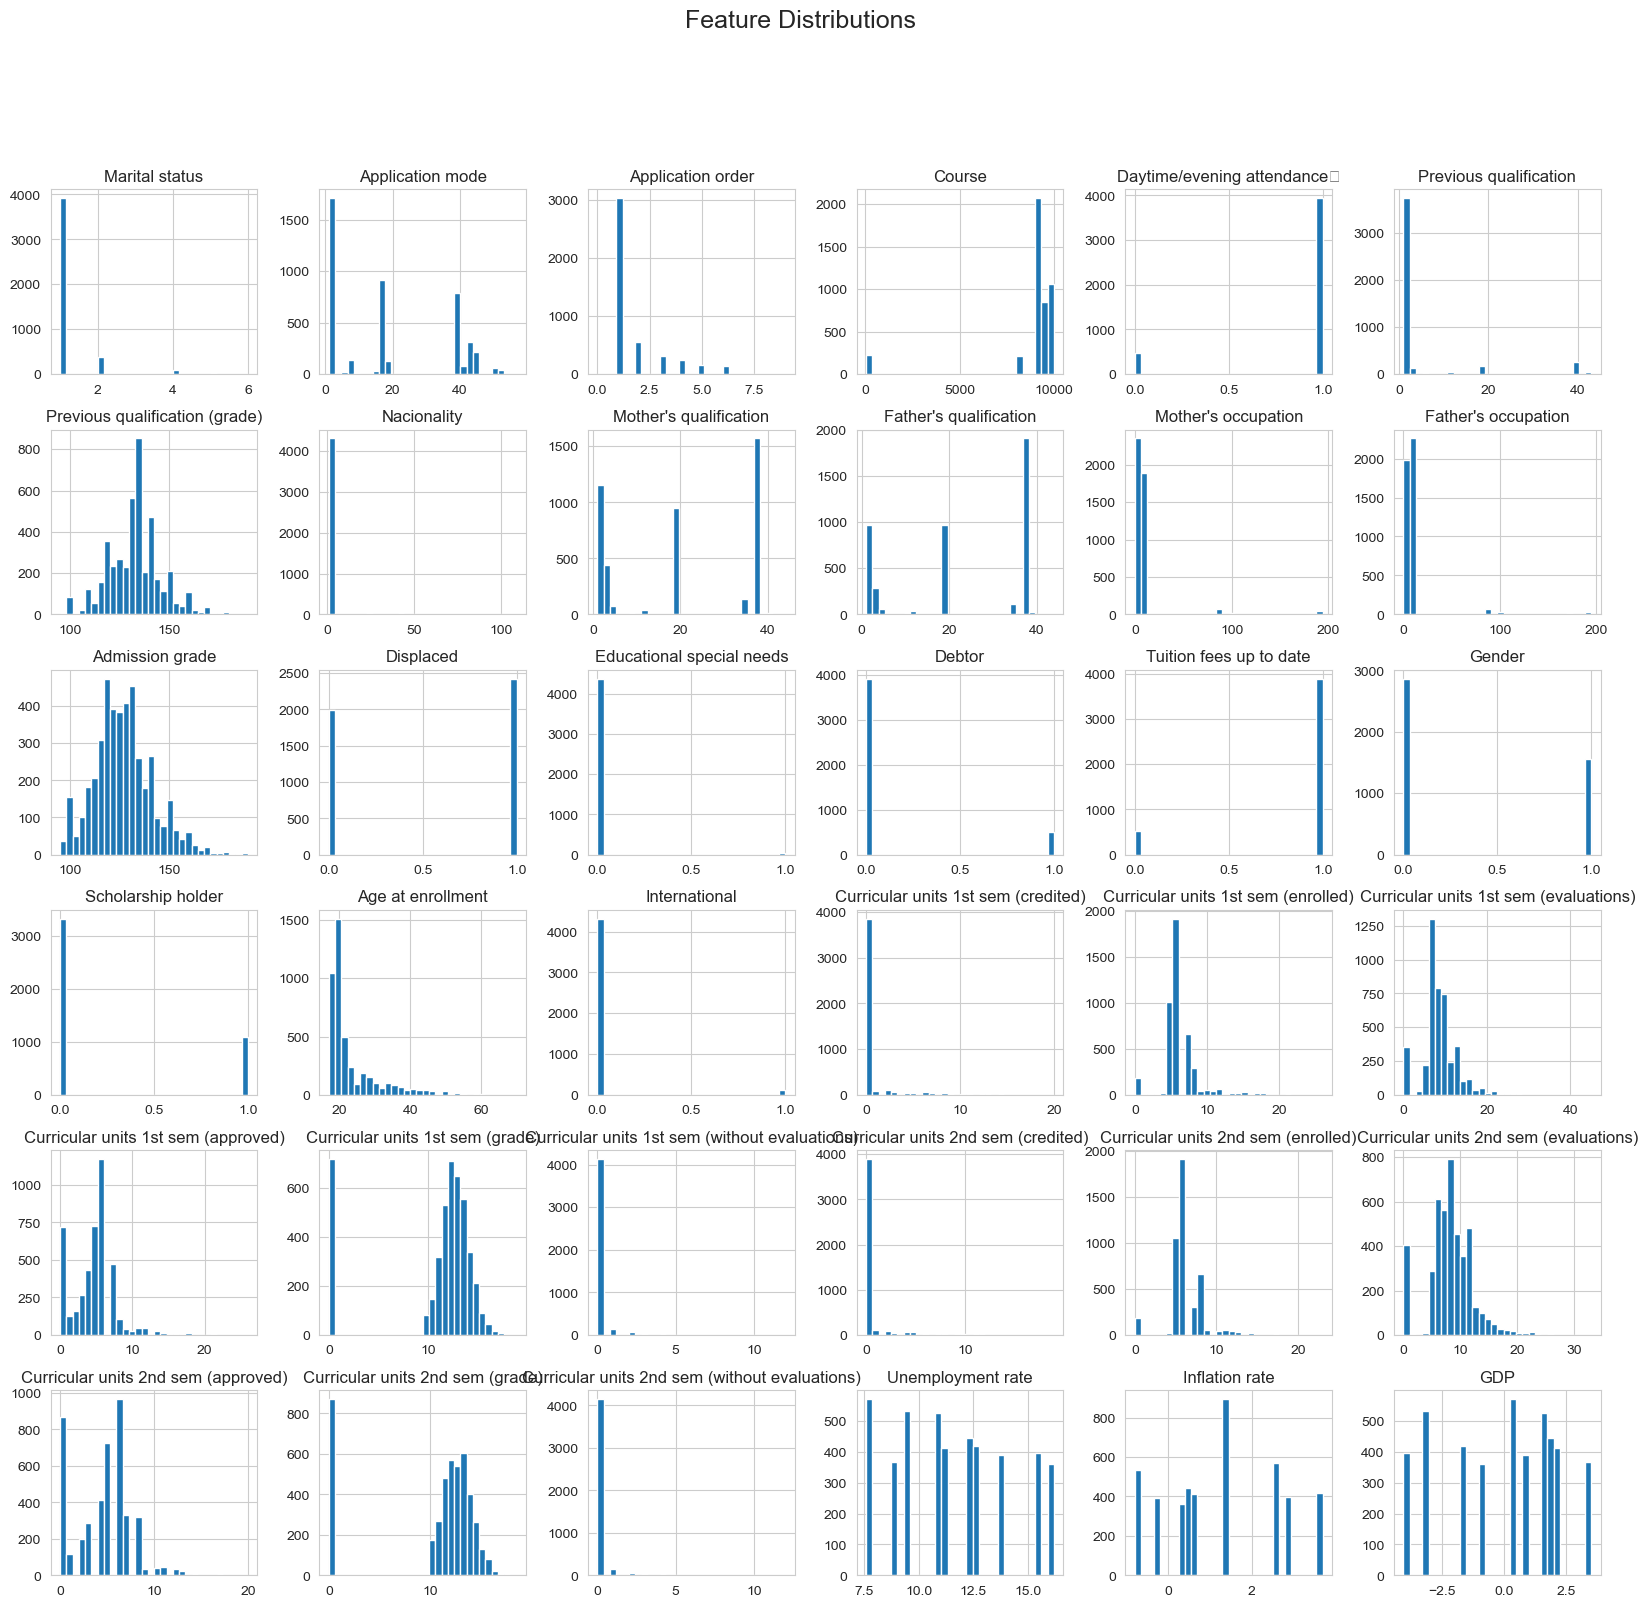

In [44]:

df.hist(figsize=(20, 18), bins=30)
plt.suptitle("Feature Distributions", fontsize=18)
plt.show()


## Class Distribution
We visualize the target variable to check for class imbalance. This step justifies the need for resampling techniques (SMOTE) later in the pipeline.

In [45]:
df['Target'].value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

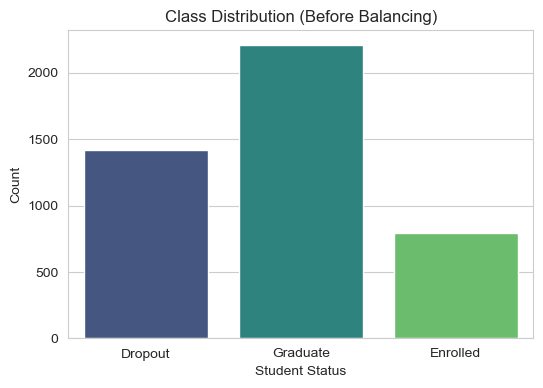

In [46]:
# 1. Class Distribution Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df, palette='viridis')
plt.title("Class Distribution (Before Balancing)")
plt.xlabel("Student Status")
plt.ylabel("Count")
plt.show()

## 3. Target Encoding
The target variable (Status) is categorical text. We convert it into numerical format (0, 1, 2) using Label Encoding so the machine learning models can process it.

In [48]:
le = LabelEncoder()
df['Target_Encoded'] = le.fit_transform(df['Target'])
class_names = le.classes_ 
print(f"Target Classes: {class_names}")

Target Classes: ['Dropout' 'Enrolled' 'Graduate']


## 4. Data Preprocessing
### 4.1 Splitting and Scaling
We define our features (X) and target (y), split the data into training (80%) and testing (20%) sets, and apply Standard Scaling. Scaling is essential for algorithms like SVM and Logistic Regression to perform correctly.

In [49]:
# 1. Define Features (X) and Target (y)
X = df.drop(['Target', 'Target_Encoded'], axis=1)
y = df['Target_Encoded']

# 2. Train-Test Split (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Standardization (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### 4.2 Handling Class Imbalance (SMOTE)
Since the dataset is imbalanced (as seen in Section 3.1), we apply SMOTE (Synthetic Minority Over-sampling Technique) to the training data. This creates synthetic examples of the minority classes (Dropout/Enrolled) to prevent the model from being biased toward Graduates.

In [50]:
print(f"Original Training Size: {len(X_train)}")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
print(f"Balanced Training Size (After SMOTE): {len(X_train_balanced)}")

Original Training Size: 3539
Balanced Training Size (After SMOTE): 5301


## 5. Model Training and Evaluation
We will now train three different models: Logistic Regression, Support Vector Machine (SVM), and Random Forest. We evaluate each using Accuracy, Classification Reports, and Confusion Matrices.

### 5.1 Logistic Regression


TRAINING MODEL 1: LOGISTIC REGRESSION
Train Accuracy: 0.7606668550437977
Test Accuracy : 0.735593220338983

Detailed Classification Report:
              precision    recall  f1-score   support

     Dropout       0.85      0.69      0.76       284
    Enrolled       0.42      0.62      0.50       159
    Graduate       0.86      0.80      0.83       442

    accuracy                           0.74       885
   macro avg       0.71      0.71      0.70       885
weighted avg       0.77      0.74      0.75       885



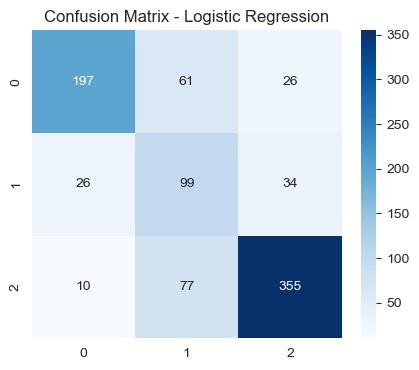

In [51]:
print("\n" + "="*40)
print("TRAINING MODEL 1: LOGISTIC REGRESSION")
print("="*40)

# Initialize and Train
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)



lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

print("Train Accuracy:", lr_train_acc)
print("Test Accuracy :", lr_test_acc)


print("\nDetailed Classification Report:")
print(classification_report(y_test, lr_test_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, lr_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### 5.2 Support Vector Machine (SVM)


TRAINING MODEL 2: SUPPORT VECTOR MACHINE (SVM)
Train Accuracy: 0.8383724215880192
Test Accuracy : 0.7096045197740113

Detailed Classification Report:
              precision    recall  f1-score   support

     Dropout       0.80      0.67      0.73       284
    Enrolled       0.39      0.57      0.47       159
    Graduate       0.83      0.79      0.81       442

    accuracy                           0.71       885
   macro avg       0.68      0.67      0.67       885
weighted avg       0.74      0.71      0.72       885



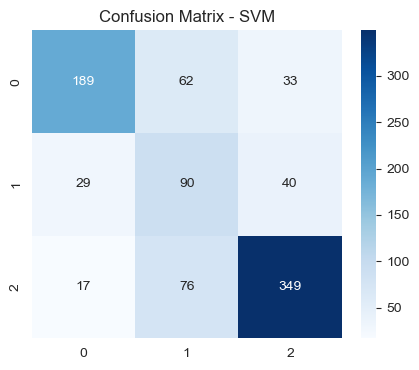

In [52]:
print("\n" + "="*40)
print("TRAINING MODEL 2: SUPPORT VECTOR MACHINE (SVM)")
print("="*40)

# Initialize and Train (probability=True needed for final inference)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_balanced, y_train_balanced)

svm_train_pred = svm_model.predict(X_train_scaled)
svm_test_pred = svm_model.predict(X_test_scaled)

svm_train_acc = accuracy_score(y_train, svm_train_pred)
svm_test_acc = accuracy_score(y_test, svm_test_pred)

print("Train Accuracy:", svm_train_acc)
print("Test Accuracy :", svm_test_acc)

print("\nDetailed Classification Report:")
print(classification_report(y_test, svm_test_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, svm_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.show()

### 5.3 Random Forest Classifier


TRAINING MODEL 3: RANDOM FOREST
Train Accuracy: 1.0
Test Accuracy : 0.7740112994350282

Detailed Classification Report (Precision, Recall, F1):
              precision    recall  f1-score   support

     Dropout       0.83      0.73      0.78       284
    Enrolled       0.53      0.52      0.52       159
    Graduate       0.83      0.89      0.86       442

    accuracy                           0.77       885
   macro avg       0.73      0.71      0.72       885
weighted avg       0.77      0.77      0.77       885



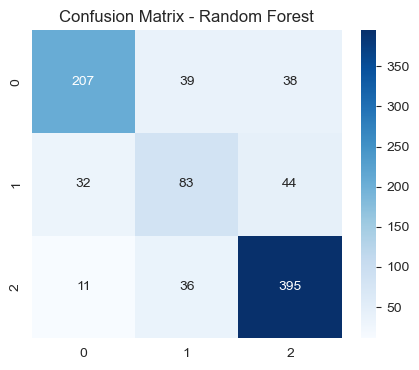

In [53]:
print("\n" + "="*40)
print("TRAINING MODEL 3: RANDOM FOREST")
print("="*40)

# Initialize and Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Predict
rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)

rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print("Train Accuracy:", rf_train_acc)
print("Test Accuracy :", rf_test_acc)

print("\nDetailed Classification Report (Precision, Recall, F1):")
print(classification_report(y_test, rf_test_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, rf_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

## 6. Hyperparameter Tuning
### We use GridSearchCV to find the best parameters for ALL models.

In [54]:

from sklearn.model_selection import GridSearchCV

tuning_results = []

# Tuning Logistic Regression 
print("Tuning Logistic Regression...")

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1], 
    'solver': ['lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=3000, random_state=42), 
                       param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)

grid_lr.fit(X_train_balanced, y_train_balanced)
best_lr = grid_lr.best_estimator_

print(f"Best Params (LR): {grid_lr.best_params_}")

Tuning Logistic Regression...
Best Params (LR): {'C': 1, 'solver': 'lbfgs'}


In [55]:
# Tuning SVM
print("Tuning SVM")


param_grid_svm = {
    'C': [0.1, 0.5, 1],        
    'gamma': ['scale', 'auto'], 
    'kernel': ['rbf']
}

grid_svm = GridSearchCV(SVC(probability=True, random_state=42), 
                        param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)

grid_svm.fit(X_train_balanced, y_train_balanced)
best_svm = grid_svm.best_estimator_

print(f"Best Params (SVM): {grid_svm.best_params_}")

Tuning SVM
Best Params (SVM): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [56]:
# Tuning Random Forest 
print("Tuning Random Forest")

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],          
    'min_samples_split': [5, 10],      
    'min_samples_leaf': [4, 6],        
    'max_features': ['sqrt']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), 
                       param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

grid_rf.fit(X_train_balanced, y_train_balanced)
best_rf = grid_rf.best_estimator_

print(f"Best Params (RF): {grid_rf.best_params_}")

Tuning Random Forest
Best Params (RF): {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}


###  6.1 Evaluating Tuned Models

In [57]:
def evaluate_tuned_model(name, model, X_train, y_train, X_test, y_test):
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Metrics
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    f1 = f1_score(y_test, test_pred, average='weighted')
    
    tuning_results.append({
        'Model': name,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'F1 Score': f1
    })
    
    print(f"--- {name} Results ---")
    print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("-" * 30)

evaluate_tuned_model("Logistic Regression (Tuned)", best_lr, X_train_balanced, y_train_balanced, X_test_scaled, y_test)
evaluate_tuned_model("SVM (Tuned)", best_svm, X_train_balanced, y_train_balanced, X_test_scaled, y_test)
evaluate_tuned_model("Random Forest (Tuned)", best_rf, X_train_balanced, y_train_balanced, X_test_scaled, y_test)

--- Logistic Regression (Tuned) Results ---
Train Acc: 0.7502 | Test Acc: 0.7356
F1 Score:  0.7482
------------------------------
--- SVM (Tuned) Results ---
Train Acc: 0.8457 | Test Acc: 0.7096
F1 Score:  0.7208
------------------------------
--- Random Forest (Tuned) Results ---
Train Acc: 0.9089 | Test Acc: 0.7492
F1 Score:  0.7536
------------------------------


## 7. Comprehensive Model Comparison
### Visualizing Before vs. After and Overfitting checks

In [58]:

base_lr_acc = accuracy_score(y_test, lr_model.predict(X_test_scaled))
base_svm_acc = accuracy_score(y_test, svm_model.predict(X_test_scaled))
base_rf_acc = accuracy_score(y_test, rf_model.predict(X_test_scaled))

tuned_lr_acc = tuning_results[0]['Test Acc']
tuned_svm_acc = tuning_results[1]['Test Acc']
tuned_rf_acc = tuning_results[2]['Test Acc']

models = ['Logistic Regression', 'SVM', 'Random Forest']
baseline_scores = [base_lr_acc, base_svm_acc, base_rf_acc]
tuned_scores = [tuned_lr_acc, tuned_svm_acc, tuned_rf_acc]


### 7.1. Plot: Before vs After Tuning


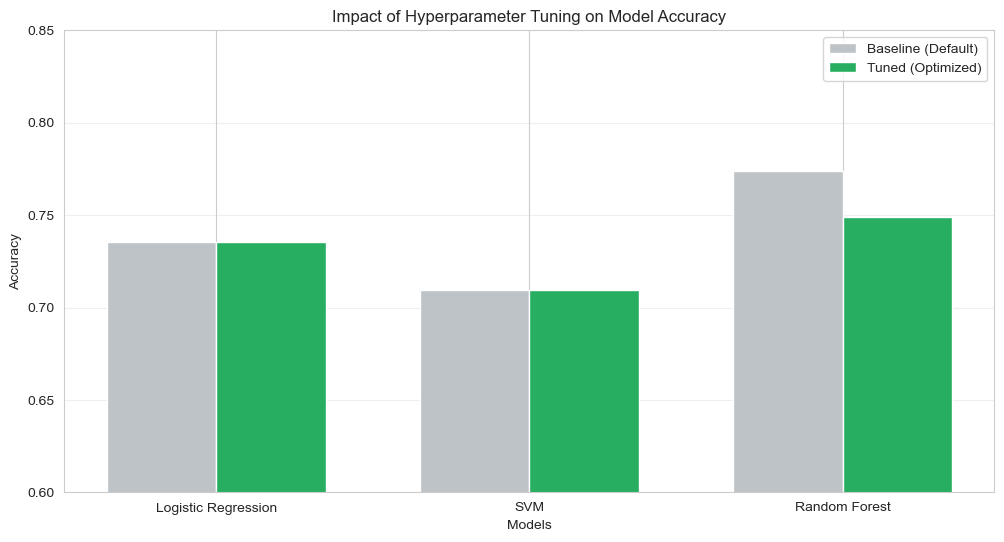

In [59]:
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, baseline_scores, width, label='Baseline (Default)', color='#bdc3c7')
plt.bar(x + width/2, tuned_scores, width, label='Tuned (Optimized)', color='#27ae60')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Impact of Hyperparameter Tuning on Model Accuracy')
plt.xticks(x, models)
plt.ylim(0.6, 0.85)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

### 7.2. Plot: Overfitting Check (Train vs Test on Tuned Models)


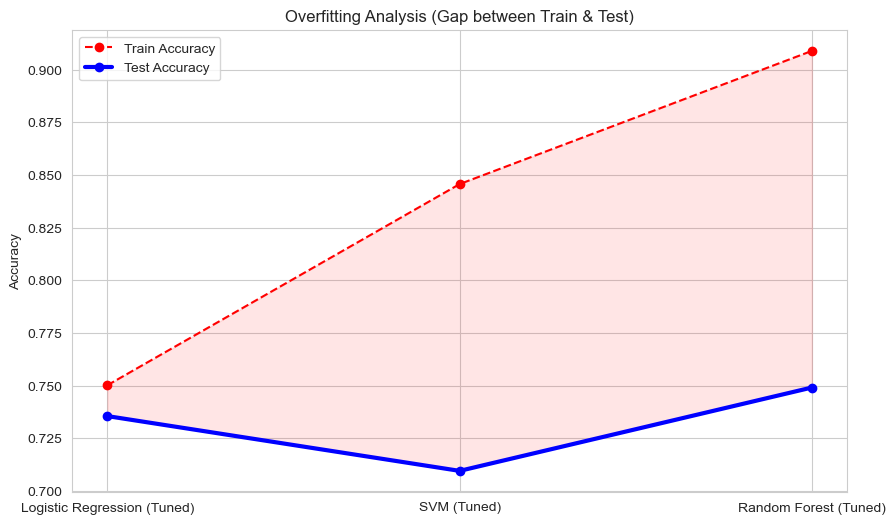

In [60]:
tuned_df = pd.DataFrame(tuning_results)

plt.figure(figsize=(10, 6))
plt.plot(tuned_df['Model'], tuned_df['Train Acc'], marker='o', linestyle='--', color='red', label='Train Accuracy')
plt.plot(tuned_df['Model'], tuned_df['Test Acc'], marker='o', linewidth=3, color='blue', label='Test Accuracy')
plt.fill_between(tuned_df['Model'], tuned_df['Test Acc'], tuned_df['Train Acc'], color='red', alpha=0.1)

plt.title("Overfitting Analysis (Gap between Train & Test)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## 8. Model Comparison 
Finally, we compare the performance of all three models side-by-side using Accuracy and Weighted F1-Score to determine the best approach.

In [61]:
from sklearn.metrics import precision_score, recall_score

# 1. Gather Predictions from the BEST Tuned Models
models = [best_lr, best_svm, best_rf]
model_names = ['Logistic Regression', 'SVM', 'Random Forest']

metrics_data = []

for name, model in zip(model_names, models):
    
    y_pred = model.predict(X_test_scaled)
    y_train_pred = model.predict(X_train_balanced)
    
    # Calculate Scores
    train_acc = accuracy_score(y_train_balanced, y_train_pred)
    test_acc = accuracy_score(y_test, y_pred)
    
    # Weighted metrics for the second chart
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    metrics_data.append([name, train_acc, test_acc, precision, recall, f1])

# Create a DataFrame
df_metrics = pd.DataFrame(metrics_data, columns=['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score'])
print("Metrics calculated successfully.")
display(df_metrics)

Metrics calculated successfully.


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.750236,0.735593,0.773598,0.735593,0.748156
1,SVM,0.845689,0.709605,0.742047,0.709605,0.720764
2,Random Forest,0.908885,0.749153,0.763689,0.749153,0.753562


### --- Chart 1: Train vs Test Accuracy ---

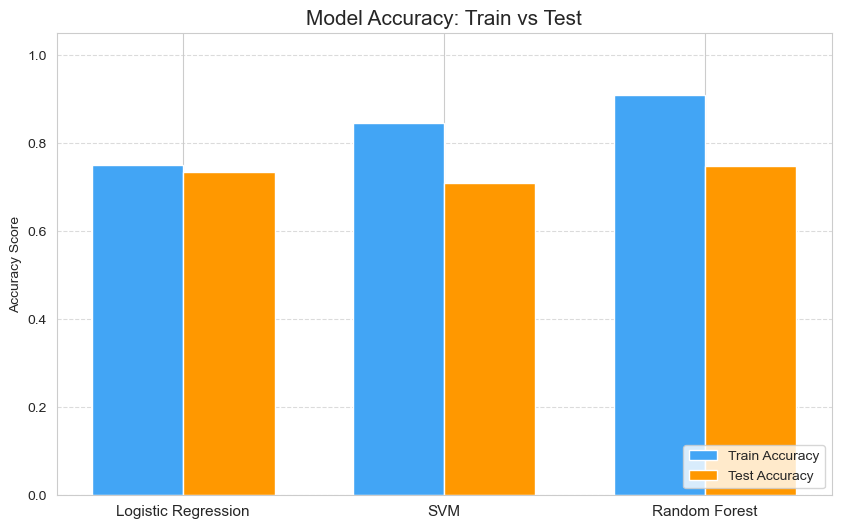

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Data setup
models = df_metrics['Model']
train_acc = df_metrics['Train Accuracy']
test_acc = df_metrics['Test Accuracy']

x = np.arange(len(models))
width = 0.35  

plt.figure(figsize=(10, 6))

# Plotting the bars
rects1 = plt.bar(x - width/2, train_acc, width, label='Train Accuracy', color='#42a5f5') 
rects2 = plt.bar(x + width/2, test_acc, width, label='Test Accuracy', color='#ff9800')   

# Labels and Title
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy: Train vs Test', fontsize=15)
plt.xticks(x, models, fontsize=11)
plt.ylim(0, 1.05)
plt.legend(loc='lower right')

# Gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### --- Chart 2: Detailed Metrics Comparison (FIXED SCALE) ---

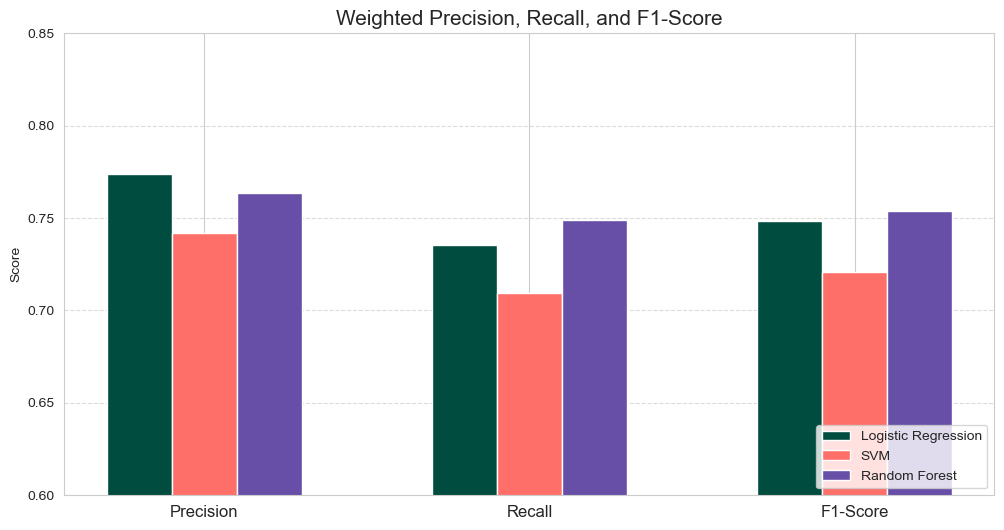

In [63]:

# Data setup
labels = ['Precision', 'Recall', 'F1-Score']

# Extracting metrics for each model
lr_scores = df_metrics.loc[0, ['Precision', 'Recall', 'F1-Score']].values
svm_scores = df_metrics.loc[1, ['Precision', 'Recall', 'F1-Score']].values
rf_scores = df_metrics.loc[2, ['Precision', 'Recall', 'F1-Score']].values

x = np.arange(len(labels))  
width = 0.2  # 

plt.figure(figsize=(12, 6))

# Plotting
plt.bar(x - width, lr_scores, width, label='Logistic Regression', color='#004d40')
plt.bar(x, svm_scores, width, label='SVM', color='#ff6f69')
plt.bar(x + width, rf_scores, width, label='Random Forest', color='#674ea7')

# Styling
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1-Score', fontsize=15)
plt.xticks(x, labels, fontsize=12)


plt.ylim(0.60, 0.85) 
# -----------------------

plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()